# Avatar Step Analysis - Heuristic Velocity Thresholding
* Version: '0.0.4'
* Date: 2021-04-23
* Author: Jea Kwon
* Description: Heuristic Rule based foot step detection of avatar instance

## Idea
When animal moves, inevitably hind foots should move. 
Therefore,
1. Velocity of foot should be near 0 when the foot is stepped. -> Set threshold for velocity to discriminate move/stop
2. Once this the time index is filtered by stop, retrieve (x, y) coords to get steps.

In [1]:
from avatarpy import Avatar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline(connected=True)

In [2]:
ava = Avatar(r'C:\Users\Jay\Downloads\3Dpose_IBS\D1_Hab_01.mp4.txt.csv')

### Aanylsis among velocity, x, y of right foot

In [3]:
rfoot = pd.DataFrame({label:ava[label]['rfoot'] for label in ['velocity', 'x', 'y']})
rfoot[:50].iplot(xTitle='Time(s)', yTitle='Position (cm)', secondary_y=['velocity'], secondary_y_title='velocity')

When we look into data, right foot coordinate is mostly staionary except when velocity is dramatically increse.  
If we threshold velocity by appropriate value, then we can find out animal is walking or not

In [4]:
rfoot['walking'] = rfoot['velocity']>3 # here, I used 3
rfoot[['walking', 'x', 'y']][:50].iplot(xTitle='Time(s)', yTitle='Position (cm)', secondary_y=['walking'], secondary_y_title='Boolean')

In [5]:
rfoot[20:20.5]

,velocity,x,y,walking
20.00,2.711347,4.898515,-2.951817,False
20.05,33.732933,3.752532,-1.714311,True
20.10,42.662030,2.212609,-0.238444,True
20.15,11.807714,1.781486,0.164894,True
20.20,1.148416,1.772025,0.219906,False
20.25,1.130885,1.762580,0.274914,False
20.30,2.644170,1.689241,0.384915,False
20.35,22.705708,0.800189,1.090710,True
20.40,20.873661,-0.015468,1.741604,True
20.45,31.578169,-1.206704,2.777390,True


`walking == False` is the stepped coordinate of right foot.  
With this boolean array, we can make series of right foot steps including parameters of,  
`step(x, y, t0, dt)`
* `x`: x coordinate
* `y`: y coordinate
* `t0`: step start time
* `dt`: duration of step

In [6]:
bool_arr = np.invert(rfoot['walking'].values)
split_indices = np.nonzero(bool_arr[1:] != bool_arr[:-1])[0] + 1
step_indices = np.split(rfoot.index, split_indices)[0::2]
steps = []
for step_index in step_indices:
    step = dict(
        x = round(rfoot.loc[step_index]['x'].mean(), 3),
        y = round(rfoot.loc[step_index]['y'].mean(), 3),
        t0 = step_index[0],
        dt = round(step_index[-1]-step_index[0], 3),
    )
    steps.append(step)
pd.DataFrame(steps)

,x,y,t0,dt
0,5.039,1.515,0.00,3.95
1,4.294,0.022,4.15,0.60
2,3.302,0.143,4.90,2.40
3,2.759,0.210,7.45,4.60
4,3.589,-1.507,12.20,1.40
...,...,...,...,...
437,4.658,-3.649,597.45,0.05
438,4.652,-1.529,597.70,0.35
439,-3.005,3.978,598.55,0.05
440,-4.750,5.615,598.80,0.80


## Hueristic thresholding function for step detection

In [7]:
def step_detection_by_velocity(avatar, foot, velocity_threshold):
    """Step detection function with velocity threshold
    
    :param obj avatar: avatar instance
    :param str foot: {'rfoot'|'lfoot'} foot node label
    :param float velocity_threshold: threshold for walking discrimination
    :return pd.DataFrame: foot steps dataframe containing x, y coordinate and start time and step duration
    
    """
    df = pd.DataFrame({label:ava[label][foot] for label in ['velocity', 'x', 'y']})
    df['walking'] = df['velocity']>velocity_threshold
    
    # get step_indices
    bool_arr = np.invert(df['walking'].values)
    split_indices = np.nonzero(bool_arr[1:] != bool_arr[:-1])[0] + 1
    step_indices = np.split(rfoot.index, split_indices)[0::2]

    # get steps as pd.DataFrame
    steps = []
    for step_index in step_indices:
        step = dict(
            x = round(rfoot.loc[step_index]['x'].mean(), 3),
            y = round(rfoot.loc[step_index]['y'].mean(), 3),
            t0 = step_index[0],
            dt = round(step_index[-1]-step_index[0], 3),
        )
        steps.append(step)
    return pd.DataFrame(steps)

# get steps

In [8]:
step_lfoot = step_detection_by_velocity(ava, 'lfoot', 3)
step_rfoot = step_detection_by_velocity(ava, 'rfoot', 3)

### Total counts of left foot steps and right foot steps

In [9]:
step_lfoot.count()[0], step_rfoot.count()[0]

(477, 442)

### Mean step duration and distribution

In [10]:
step_lfoot.dt.mean(), step_rfoot.dt.mean() # sec

(1.0439203354297695, 1.1457013574660633)

<AxesSubplot:ylabel='Frequency'>

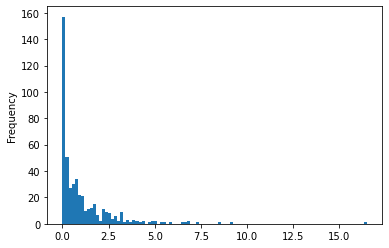

In [11]:
step_lfoot.dt.plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

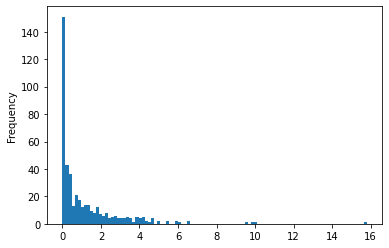

In [12]:
step_rfoot.dt.plot.hist(bins=100)

### Plotting left and right foots on xy plane

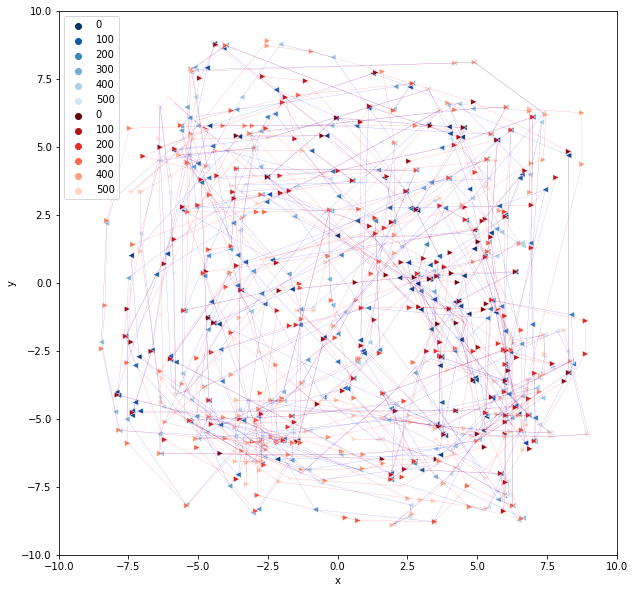

In [13]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=step_lfoot, x='x', y='y', hue='t0', marker='<', palette='Blues_r')
sns.scatterplot(data=step_rfoot, x='x', y='y', hue='t0', marker='>', palette='Reds_r')
plt.plot(step_lfoot['x'], step_lfoot['y'], c='blue', linewidth=0.1)
plt.plot(step_rfoot['x'], step_rfoot['y'], c='red', linewidth=0.1)
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.legend()

### Implication
With this analysis, it can be used for detection of specific position where animal stepped.
Not only that, avareage step durations, average inter-step distances, can be calculated for parameters.

### Advantage
Intuitive.

### Limitation
However, reliability of this heuristic step detection method depends on optimal selection of velocity threshold.
See below examples of 3 different threshold, 1, 3, 10

### Todos
Can we automatically detect optimal threshold for velocity?
Or is there other way of detecting steps?

In [60]:
rfoot['walking'] = rfoot['velocity']>1
rfoot[['walking', 'x', 'y']][:10].iplot(xTitle='Time(s)', yTitle='Position (cm)', secondary_y=['walking'], secondary_y_title='Boolean')

In [61]:
rfoot['walking'] = rfoot['velocity']>3
rfoot[['walking', 'x', 'y']][:10].iplot(xTitle='Time(s)', yTitle='Position (cm)', secondary_y=['walking'], secondary_y_title='Boolean')

In [62]:
rfoot['walking'] = rfoot['velocity']>10
rfoot[['walking', 'x', 'y']][:10].iplot(xTitle='Time(s)', yTitle='Position (cm)', secondary_y=['walking'], secondary_y_title='Boolean')

Threshold value 3(second one) serparate relatively well compared to others.